In [1]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Dense,Conv2D,Dropout,MaxPooling2D,GlobalMaxPooling2D,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import keras
from keras import layers
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
img_dir_pat='/Users/draculalemon/Downloads/face_mask'

In [3]:
img_class=[]
for class_names in os.listdir(img_dir_pat):
    class_mask_path=os.path.join(img_dir_pat,class_names)
    if os.path.isdir(class_mask_path):
        no_of_img=len(os.listdir(class_mask_path))
        img_class.append(class_names)
        print(no_of_img)
# for class_name in os.listdir(dir_pat):
#     class_path=os.path.join(dir_pat,class_name)
#     if os.path.isdir(class_path):
#         no_of_img=len(os.listdir(class_path))
#         img_class.append((class_name))
#         print(no_of_img)  

962
1000


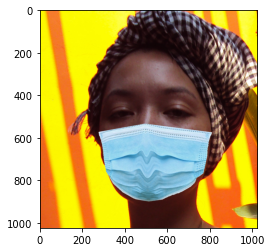

In [4]:
#now we will look of a sample image from both mask and without mask
mask=cv2.imread("/Users/draculalemon/Downloads/face_mask/01000/01296_Mask.jpg")
plt.imshow(cv2.cvtColor(mask,cv2.COLOR_BGR2RGB))


In [5]:
IMG_height=224
IMG_WEIGHT=224
split=0.2

datagen_train=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                             validation_split=split)

datagen_val=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            validation_split=split)

In [6]:
#passing the image generator to the file or applying it
train_data=datagen_train.flow_from_directory(batch_size=20,directory=img_dir_pat,
                                            shuffle=True,
                                            subset='training',
                                            interpolation='bicubic',
                                            target_size=(IMG_height,IMG_WEIGHT))

validate_data=datagen_val.flow_from_directory(batch_size=20,directory=img_dir_pat,
                                    shuffle=True,
                                    subset='validation',
                                    interpolation='bicubic',
                                    target_size=(IMG_height,IMG_WEIGHT))

Found 1570 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


In [7]:
# reseting the index after split
validate_data.reset()
train_data.reset()

In [8]:

model=Sequential([
    Conv2D(16,3,padding='same',activation='relu',input_shape=(IMG_height,IMG_WEIGHT,3)),
    MaxPooling2D(),
    
    Conv2D(32,3,padding='same',activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64,3,padding='same',activation='relu'),
    MaxPooling2D(),
    
    Conv2D(128,3,padding='same',activation='relu'),
    MaxPooling2D(),
    
    Conv2D(256,3,padding='same',activation='relu'),
    MaxPooling2D(),
    
    Conv2D(512,3,padding='same',activation='relu'),
    MaxPooling2D(),
       
    GlobalMaxPooling2D(),
    Dense(1000,activation='relu'),
    Dense(len(img_class),activation='softmax')
        
])

Metal device set to: Apple M1


2022-07-23 16:05:54.507575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-23 16:05:54.507696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
#using early stoping for preventing overfiting
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=6,mode='min',
                                      restore_best_weights=True)
batch_size=5

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',
             metrics=['accuracy'])

In [11]:
start = time.time()
epoches=5
train_model=model.fit(train_data,
                  epochs=epoches,validation_data=validate_data,
                  validation_steps=(validate_data.samples)//batch_size,
                  callbacks=[early_stopping_callback])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/5


2022-07-23 16:05:55.116308: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-23 16:05:55.446899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9032

2022-07-23 16:06:29.560944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 43s 539ms/step - loss: 0.2103 - accuracy: 0.9032 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 2/5
79/79 [==============================] - 34s 427ms/step - loss: 0.0023 - accuracy: 0.9994
Epoch 3/5
79/79 [==============================] - 34s 428ms/step - loss: 9.4612e-04 - accuracy: 0.9994
Epoch 4/5
79/79 [==============================] - 34s 427ms/step - loss: 0.0126 - accuracy: 0.9962
Epoch 5/5
79/79 [==============================] - 34s 429ms/step - loss: 0.1186 - accuracy: 0.9771
Training time: 179.23262095451355s


In [16]:
#saving the model
model.save('mask_file.h5')